In [26]:
import numpy as np
import matplotlib.pyplot as plt
from kernel import Kernel

In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"
plt.rc('text', usetex=True)

np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
def get_eta(x, m=3):
    p = np.zeros((len(x), m), dtype=float)

    to_visit = np.ones(x.shape, dtype=bool)
    ind = x < .25
    p[ind] = 0
    p[ind, 0] = 1
    p[ind] += 4 * x[ind, np.newaxis] / m
    p[ind, 0] -= 4 * x[ind]
    to_visit[ind] = 0

    ind[:] = x < .5
    ind &= to_visit
    p[ind] = 1/m
    p[ind] -= 4 * (x[ind, np.newaxis] - .25) / m
    p[ind, 1] += 4 * (x[ind] - .25)
    to_visit[ind] = 0

    ind[:] = x < .75
    ind &= to_visit
    p[ind] = 0
    p[ind, 1] = 1
    p[ind] += 4 * (x[ind, np.newaxis] - .5) / m
    p[ind, 1] -= 4 * (x[ind] - .5)
    to_visit[ind] = 0

    ind[:] = to_visit
    p[ind] = 1 / m
    p[ind] -= 4 * (x[ind, np.newaxis] - .75) / m
    p[ind, 2] += 4 * (x[ind] - .75)
    
    return p


def get_samples_from_p(p):
    repartition_p = np.cumsum(p, axis=1)
    u = np.random.rand(p.shape[0])[:, np.newaxis]
    return (u > repartition_p).sum(axis=1)


def get_labels(x, m=3):
    return get_samples_from_p(get_eta(x, m=m))

def get_one_hot(y, m=None):
    n = len(y)
    if m is None:
        m = np.max(y) + 1

    out = np.zeros((n, m), float)
    out[np.arange(n), y] = 1
    return out

def get_num(y):
    return y.argmax(axis=1)

def get_inputs(num, epsilon=.05, test=False):
    """Generate uniform inputs on interval with holes

    The interval is defined as :math:`X([0, 1] \backslash [.25-\epsilon, .25+\epsilon] \backslash [.75-\epsilon, .75+\epsilon])`
    Useful to make sure that our examples verifies a hard margin condition leading to exponential convergence rates.

    Args:
        num (int): Number of samples to generate.
        epsilon (float, optional): Specify hole width. Default in .05.
        test (bool, optional): If specified, it returns deterministic samples that are uniformly spreads out. Default is False.

    Returns:
        x (ndarray): Samples in :math:`[0, 1]` as a 1d NumPy array.
    """
    if test:
        x = np.linspace(0, 1, num=num)
    else:
        x = np.random.rand(num) 
    x *= 1 - 4 * epsilon
    x[x > .25 - epsilon] += 2*epsilon
    x[x > .75 - epsilon] += 2*epsilon 
    return x


def generate_random_sphere(n_train, m):
    u = np.random.randn(n_train, m)
    u /= np.sqrt(np.sum(u**2, axis=1))[:, np.newaxis]
    return u

def generate_random_coordinate(n_train, m):
    u = np.random.randn(n_train, m)
    return (u == u.max(axis=1)[:, np.newaxis]).astype(float)

def get_stepsize(T, gamma_0=1):
    gamma = np.arange(T, dtype=float)
    gamma += 1
    np.sqrt(gamma, out=gamma)
    np.divide(1, gamma, out=gamma)
    gamma *= gamma_0
    return gamma

In [29]:
m = 3
n_train = int(1e3)
x_train = get_inputs(n_train)
y_train_num = get_labels(x_train, m=m)
y_train = get_one_hot(y_train_num, m=m)

n_test = int(1e2)
x_test = get_inputs(n_test, test=True)
p_test = get_eta(x_test, m=m)
y_test = get_num(p_test)

gamma_0 = 5
gamma = get_stepsize(n_train, gamma_0)
u = generate_random_sphere(n_train, m)
u_coor = generate_random_coordinate(n_train, m)

sigma = .2
kernel = Kernel('gaussian', sigma=sigma)
kernel.set_support(x_train[:, np.newaxis])
K = kernel(x_train[:, np.newaxis])
k_test = kernel(x_test[:, np.newaxis]).T

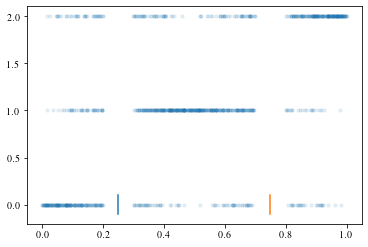

In [30]:
plt.scatter(x_train, y_train_num, alpha=.1, s=10)
plt.plot([.25, .25], [-.1, .1])
plt.plot([.75, .75], [-.1, .1])

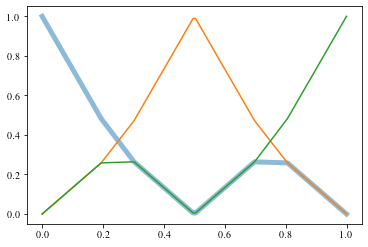

In [31]:
plt.plot(x_test, p_test[:, 0], lw=5, alpha=.5)
plt.plot(x_test, p_test[:, 1])
plt.plot(x_test, p_test[:, 2])

In [32]:
def get_error(y_num, p_test, y_test=None):
    if y_test is None:
        y_test = get_num(p_test)
    n_test = len(y_test)
    ind = np.arange(n_test)
    return (p_test[ind, y_test] - p_test[ind, y_num]).mean()

In [39]:
n_exp = 40
m = 100
n_train = int(1e4)

alpha = np.zeros((n_train, m), np.float32)
average_alpha = np.zeros((n_train, m), np.float32)
err = np.zeros((n_exp, n_train), np.float32)

alpha_bis = np.zeros((n_train, m), np.float32)
average_alpha_bis = np.zeros((n_train, m), np.float32)
err_bis = np.zeros((n_exp, n_train), np.float32)

n_test = int(1e2)
x_test = get_inputs(n_test, test=True)
p_test = get_eta(x_test, m=m)
y_test = get_num(p_test)

gamma_0 = 1
gamma = get_stepsize(n_train, gamma_0)

sigma = .2
kernel = Kernel('gaussian', sigma=sigma)
K = np.zeros((n_train, n_train), dtype=np.float32)
k_test = np.zeros((n_test, n_train), dtype=np.float32)

for j in range(n_exp):
    x_train = get_inputs(n_train).astype(np.float32)
    y_train = get_one_hot(get_labels(x_train, m=m), m=m).astype(np.float32)
    kernel.set_support(x_train[:, np.newaxis])
    K[:] = kernel(x_train[:, np.newaxis])
    k_test[:] = kernel(x_test[:, np.newaxis]).T

    u = generate_random_sphere(n_train, m).astype(np.float32)
    u_coor = generate_random_coordinate(n_train, m).astype(np.float32)

    alpha[:] = 0
    average_alpha[:] = 0

    alpha_bis[:] = 0
    average_alpha_bis[:] = 0
    
    for i in range(n_train):
        epsilon = np.sign(np.dot(K[i, :i+1] @ alpha[:i+1] - y_train[i], u[i]))
        alpha[i] -= epsilon * gamma[i] * u[i]
        average_alpha += alpha

        epsilon_bis = np.sign(np.dot(K[i, :i+1] @ alpha_bis[:i+1] - y_train[i], u_coor[i]))
        alpha_bis[i] -= epsilon_bis * gamma[i] * u_coor[i]
        average_alpha_bis += alpha_bis
        
        y_num = get_num(k_test[:, :i+1] @ average_alpha[:i+1])
        y_num_bis = get_num(k_test[:, :i+1] @ average_alpha_bis[:i+1])
        err[j, i] = get_error(y_num, p_test, y_test=y_test)
        err_bis[j, i] = get_error(y_num_bis, p_test, y_test=y_test)

    print(j, end=',', flush=True)

# y_pred = k_test @ alpha
# y_pred_bis = k_test @ alpha_bis

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,

In [40]:
ave_error = err.mean(axis=0)
std_error = err.std(axis=0)
ave_error_bis = err_bis.mean(axis=0)
std_error_bis = err_bis.std(axis=0)

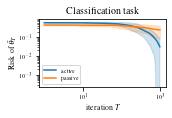

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 1.75))
ax.fill_between(np.arange(n_train) + 1, ave_error + std_error, ave_error - std_error, color='C0', alpha=.2)
a, = ax.plot(np.arange(n_train) + 1, ave_error, c='C0')
ax.fill_between(np.arange(n_train) + 1, ave_error_bis + std_error_bis, ave_error_bis - std_error_bis, color='C1', alpha=.2)
b, = ax.plot(np.arange(n_train) + 1, ave_error_bis, c='C1')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend([a, b], ['active', 'passive'], prop={'size': 6})
plt.yticks(fontsize=6)
plt.xticks(fontsize=6)
ax.set_title(r'Classification task', size=10)
ax.set_xlabel(r"iteration $T$", size=8)
ax.set_ylabel(r"Risk of $\bar\theta_T$", size=8)
fig.tight_layout()
# fig.savefig("classification_error.pdf")